In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import scipy.io as sio
import glob
import cv2
from sklearn import svm
from scipy import signal
from skimage.filters import threshold_otsu
from matplotlib.patches import Circle
from sklearn.cluster import KMeans
from scipy import stats
sns.set_theme()
root='/content/drive/MyDrive/TrainModels/'

### Functions

In [ ]:
def random_plot():
  rand=2*np.random.choice(int(sizx[0]/2))
  t1='_'.join([Subj[rand],str(labe[rand]),Gend[rand],Late[rand]])
  t2='_'.join([Subj[rand+1],str(labe[rand+1]),Gend[rand+1],Late[rand+1]])

  plt.figure(figsize=(14,7))
  plt.subplot(1,6,1)
  plt.imshow(temp[rand], cmap='inferno', vmin=mini, vmax=maxi)
  plt.title(t1)
  plt.axis('off')

  plt.subplot(1,6,2)
  plt.imshow(angi[rand])
  plt.title(t1)
  plt.axis('off')

  plt.subplot(1,6,3)
  plt.imshow(temp[rand+1], cmap='inferno', vmin=mini, vmax=maxi)
  plt.title(t2)
  plt.axis('off')

  plt.subplot(1,6,4)
  plt.imshow(angi[rand+1])
  plt.title(t2)
  plt.axis('off')

  print('Índice :', rand)

### Centros
Se crearon para determinar si los centros difieren entre CG y DM.
Era para ver si la diferencia entre el centro termico y el geometrico de CG y DM eran diferntes. 

In [ ]:
# función para calcular el centro geométrico de las imáges termicas (pie).
def geometric_center(ref, show=False):
  ima=ref.copy()  
  yp,xp=np.shape(ima)
  xc=np.sum(ima!=0, axis=0)@np.arange(xp)/np.sum(ima!=0)
  yc=np.sum(ima!=0, axis=1)@np.arange(yp)/np.sum(ima!=0)
  ima[:,int(xc)]=0
  ima[int(yc),:]=0
  if show:
    plt.imshow(ima, cmap='inferno', vmin=mini, vmax=maxi)
    plt.title('Centro geométrico')
    plt.axis('off')
  return xc,yc

In [ ]:
# función para calcular el centro térmico.
def geometric_temp(ref, show=False):
  ima=ref.copy()
  yp,xp=np.shape(ima)
  xc=np.sum(ima, axis=0)@np.arange(xp)/np.sum(ima)
  yc=np.sum(ima, axis=1)@np.arange(yp)/np.sum(ima)
  ima[:,int(xc)]=maxi
  ima[int(yc),:]=maxi
  if show:
    plt.imshow(ima, cmap='inferno', vmin=mini, vmax=maxi)
    plt.title('Centro térmico')
    plt.axis('off')
  return xc,yc

### Datos

In [ ]:
#Altura y pesos no están completos
info=pd.read_csv(root+'ThermoDataBase.csv')
infA=sio.loadmat(root+'infoadd.mat')
info.head()

,Subject,Gender,Age,Weight,Heigh,IMC,General_R,LCA_R,LPA_R,MCA_R,MPA_R,TCI_R,General_L,LCA_L,LPA_L,MCA_L,MPA_L,TCI_L
0,DM001,M,55.0,82.0,1.66,29.76,32.47,32.08,32.70,32.36,32.79,6.48,32.09,31.53,32.39,31.81,32.39,6.03
1,DM002,M,60.0,90.0,1.71,30.78,26.99,26.54,26.95,26.84,27.38,0.93,26.33,26.39,25.93,26.75,26.45,0.38
2,DM003,F,66.0,NaN,NaN,NaN,28.04,28.22,27.57,29.06,27.70,2.14,27.19,26.96,26.96,27.90,27.38,1.30
3,DM004,M,57.0,NaN,NaN,NaN,32.32,31.67,32.54,31.86,32.61,6.17,30.71,29.78,30.96,31.04,30.72,4.62
4,DM005,M,40.0,NaN,NaN,NaN,24.48,24.19,24.48,24.26,24.52,1.64,25.36,24.40,25.72,24.88,25.57,0.87


In [ ]:
data=sio.loadmat(root+'DM_Data.mat')
pixv={'LCA': 1, 'LPA': 2, 'MCA': 4, 'MPA': 8}  #valores de etiquetas para graficar.

In [ ]:
temp=data['Temp']
angi=data['Angiosoms']
Subj=data['Subject']
labe=data['Type'][0]
Gend=data['Gender']
Late=data['Laterality']
sizx=np.shape(temp)
maxi=np.max(temp)
mini=np.min(temp[temp!=0])

$ tci_{der}=tci_{der}*\sqrt((tci_{izq} - tci_{der})**2) $

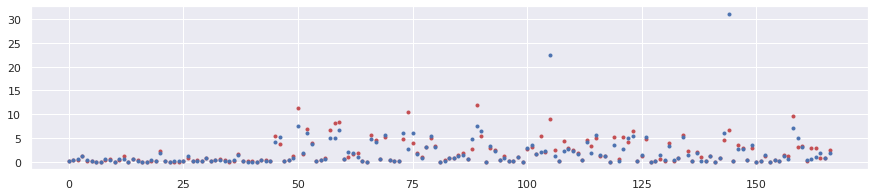

In [ ]:
#gráfico 1. Diferencial de temperatura.
plt.figure(figsize=(15,3))
der=infA['TCI'][0][Late=='R']
izq=infA['TCI'][0][Late=='L']
Delder=der*np.sqrt((der-izq)**2)
Delizq=izq*np.sqrt((der-izq)**2)
plt.plot(Delder, '.r')
plt.plot(Delizq, '.b')

![angiosomas.jpg](https://www.mdpi.com/sensors/sensors-20-01762/article_deploy/html/images/sensors-20-01762-g003-550.jpg)

Se gráficaron los angiosomas con diferentes valores, son 4 angiosomas, pero hay dos que están superpuestos, por lo tanto, los dos superpuesto tienen la suma de los dos valores.

Índice : 182


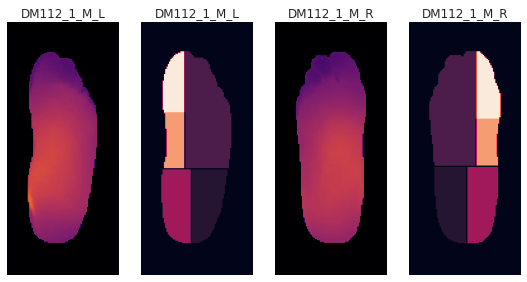

In [ ]:
#gráfico 2
random_plot()

(43.25665349279049, 95.17438097708242)

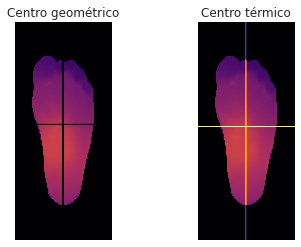

In [ ]:
# visualización entre centros. #Gráfico 3
plt.subplot(1,2,1)
geometric_center(temp[0], True)
plt.subplot(1,2,2)
geometric_temp(temp[0], True)

### Similaridad

In [ ]:
def unbiased_HSIC(K, L):
  '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

  #create the unit **vector** filled with ones
  n = K.shape[0]
  ones = np.ones(shape=(n))

  #fill the diagonal entries with zeros 
  np.fill_diagonal(K, val=0) #this is now K_tilde 
  np.fill_diagonal(L, val=0) #this is now L_tilde

  #first part in the square brackets
  trace = np.trace(np.dot(K, L))

  #middle part in the square brackets
  nominator1 = np.dot(np.dot(ones.T, K), ones)
  nominator2 = np.dot(np.dot(ones.T, L), ones)
  denominator = (n-1)*(n-2)
  middle = np.dot(nominator1, nominator2) / denominator
  
  
  #third part in the square brackets
  multiplier1 = 2/(n-2)
  multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
  last = multiplier1 * multiplier2

  #complete equation
  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic

In [ ]:
def CKA(X, Y):
  '''Computes the CKA of two matrices. This is equation (1) from the paper'''
  
  nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
  denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
  denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

  cka = nominator/np.sqrt(denominator1*denominator2)

  return cka

In [ ]:
def calculate_CKA_for_two_matrices(activationA, activationB):
  '''Takes two images A and B and computes the linear CKA to measure their similarity'''

  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

  shape = activationB.shape
  activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

  #calculate the CKA score
  cka_score = CKA(activationA, activationB)

  del activationA
  del activationB

  return cka_score

In [ ]:
mtx=np.zeros((np.shape(temp)[0],np.shape(temp)[0]))
for ni,i in enumerate(temp):
  for nj,j in enumerate(temp):
    mtx[ni,nj]=calculate_CKA_for_two_matrices(i,j)  

### Comparación de similitud
Se compararon las imágenes térmicas de todos los sujetos. Se utilizarón las 334 imágenes térmicas de los 167 sujetos 45 CG y 122 DM. Los primeras 90 imágenes corresponden a los 45 CG.

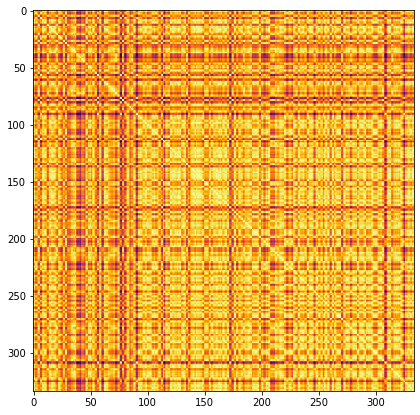

In [ ]:
# gráfico 4
plt.figure(figsize=(7,7))
plt.imshow(mtx, cmap='inferno', vmin=0.34, vmax=1)

### Similiridad entre pies

In [ ]:
res=[]
for i in range(int(np.shape(temp)[0]/2)):
  res.append(calculate_CKA_for_two_matrices(temp[2*i],np.flip(temp[2*i+1], axis=1))) 

In [ ]:
tm=np.sum(temp!=0, axis=(1,2))
gr=np.sum(temp,axis=(1,2))

In [ ]:
#Gráfico 5
plt.figure(figsize=(15,3))
plt.plot(infA['General'][0][Late=='R'], '.g')
plt.plot((gr/tm)[Late=='R'])
plt.plot(np.array(res)*15, '.b')

### Similaridad utilizando k-means para generar mapas de distribución de temperaturas

0.5804985143989065

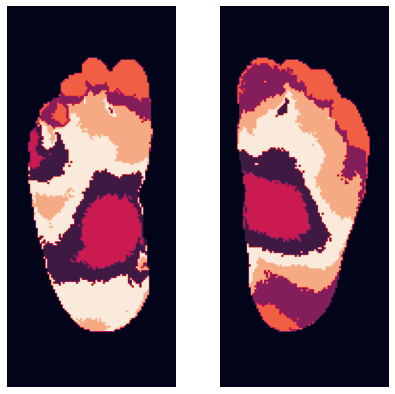

In [ ]:
#gráfica 6.
def similaridad_kmeans(indice, clusters=7, show=False):
  indice=indice-(indice%2)
  kmeans = KMeans(n_clusters=clusters, random_state=0)
  y,x=np.mgrid[0:np.shape(temp)[1],0:np.shape(temp)[2]]
  y1=y*(temp[indice]!=0)
  x1=x*(temp[indice]!=0)-88
  y2=y*(temp[indice+1]!=0)
  x2=x*(temp[indice+1]!=0)

  imaX=np.concatenate((temp[indice].reshape((199*88,1)), temp[indice+1].reshape((199*88,1))))
  y=np.concatenate((y1.reshape((199*88,1)),y2.reshape((199*88,1))))
  x=np.concatenate((x1.reshape((199*88,1)),x2.reshape((199*88,1))))

  fea=np.concatenate((imaX,imaX*np.log(imaX+1),imaX**2), axis=1)
  kmeans.fit(fea)
  uno=kmeans.labels_[:199*88].reshape((199,88))
  dos=kmeans.labels_[199*88:].reshape((199,88))

  if show:
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.imshow(uno)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(dos)
    plt.axis('off')
  
  return calculate_CKA_for_two_matrices(uno, np.flip(dos, axis=1))

ind=np.random.choice(167)
similaridad_kmeans(ind, show=True)

In [ ]:
rre=[]
for i in range(167):
  rre.append(similaridad_kmeans(i))

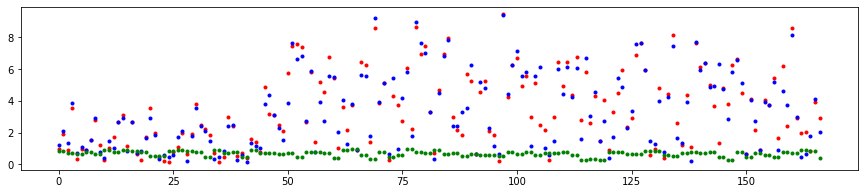

In [ ]:
#gráfico 7. Similitud entre los patrones generados por k-meas con 7 clases.
plt.figure(figsize=(15,3))
der=infA['TCI'][0][Late=='R']
izq=infA['TCI'][0][Late=='L']
plt.plot(der, '.r')
plt.plot(izq, '.b')
plt.plot(rre, '.g')

### Histograma

In [ ]:
bins=100
hisM0=np.zeros((np.shape(temp)[0],bins))
for i in range(np.shape(temp)[0]):
  y,x=np.histogram(temp[i], bins=bins, range=[mini, maxi])
  hisM0[i]=y

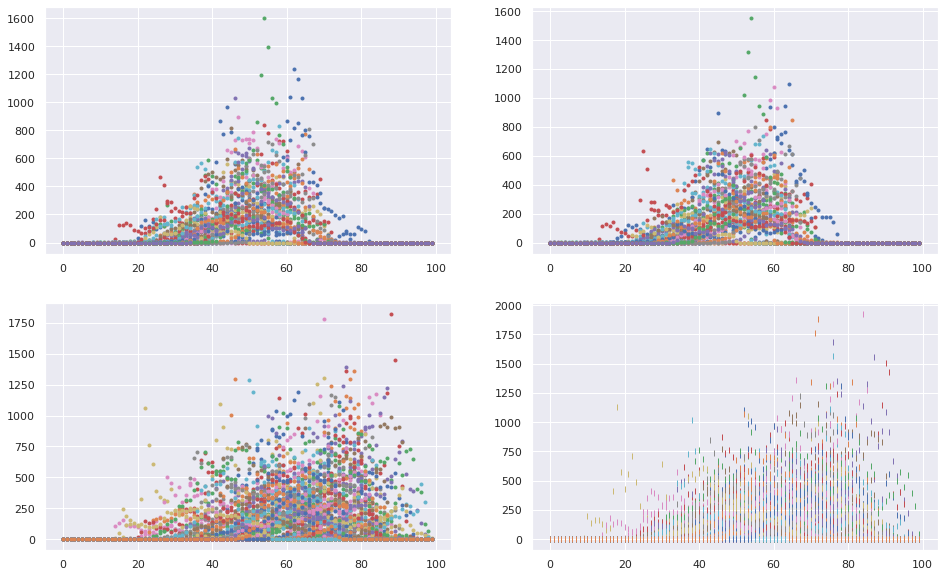

In [ ]:
#Gráfico 8. Histogramas de temperaturas de CG derecho, CG izquierdo, DM derecho y DM izquierdo.
hisM=np.diff(hisM0, n=0)
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.plot(hisM[Late=='R'][:45].T, '.')

plt.subplot(2,2,2)
plt.plot(hisM[Late=='L'][:45].T, '.')

plt.subplot(2,2,3)
plt.plot(hisM[Late=='R'][45:].T, '.')

plt.subplot(2,2,4)
plt.plot(hisM[Late=='L'][45:].T, '|'); print('')

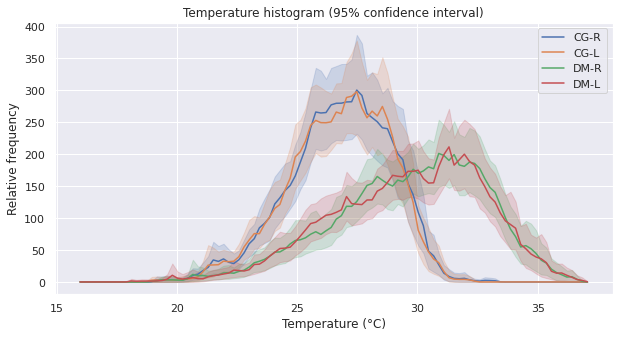

In [ ]:
#Gráfico 9. Histogramas promedio de las temperaturas de los pies.
plt.figure(figsize=(10,5))
hisM=hisM0[Late=='R'][:45]
xr=[x[:-1] for i in range(np.shape(hisM)[0])]
sns.lineplot(x=np.array(xr).reshape(hisM.size),y=np.array(hisM).reshape(hisM.size))

hisM=hisM0[Late=='L'][:45]
xr=[x[:-1] for i in range(np.shape(hisM)[0])]
sns.lineplot(x=np.array(xr).reshape(hisM.size),y=np.array(hisM).reshape(hisM.size))

hisM=hisM0[Late=='R'][45:]
xr=[x[:-1] for i in range(np.shape(hisM)[0])]
sns.lineplot(x=np.array(xr).reshape(hisM.size),y=np.array(hisM).reshape(hisM.size))

hisM=hisM0[Late=='L'][45:]
xr=[x[:-1] for i in range(np.shape(hisM)[0])]
sns.lineplot(x=np.array(xr).reshape(hisM.size),y=np.array(hisM).reshape(hisM.size))
plt.title('Temperature histogram (95% confidence interval)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Relative frequency')
plt.legend(['CG-R', 'CG-L', 'DM-R', 'DM-L'])
plt.savefig(root+'Histogramas.svg')

In [ ]:
from sklearn.decomposition import PCA
nx=15

pca_h0=PCA(15)
pca_h0.fit(hisM0[Late=='R'][:45])

pca_h1=PCA(15)
pca_h1.fit(hisM0[Late=='L'][:45])

pca_h2=PCA(15)
pca_h2.fit(hisM0[Late=='R'][45:])

pca_h3=PCA(15)
pca_h3.fit(hisM0[Late=='L'][45:])

PCA(n_components=15)

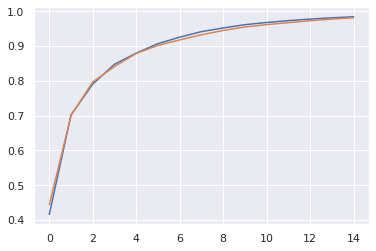

In [ ]:
# varianza en función del número de componentes principales
plt.plot(np.cumsum(pca_h0.explained_variance_ratio_))
plt.plot(np.cumsum(pca_h1.explained_variance_ratio_))

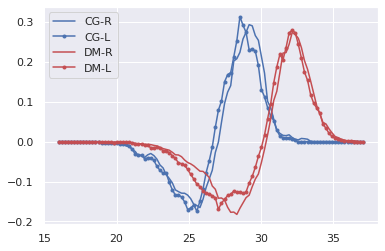

In [ ]:
#Gráfico 11. Gráfico de la primera componente principal de cada caso.
nco=0
plt.plot(x[:-1], pca_h0.components_[nco], 'b')
plt.plot(x[:-1], pca_h1.components_[nco], '.-b')
plt.plot(x[:-1], pca_h2.components_[nco], 'r')
plt.plot(x[:-1], pca_h3.components_[nco], '.-r')
plt.legend(['CG-R', 'CG-L', 'DM-R', 'DM-L'])

In [ ]:
hiscg=np.mean(hisM0[:90], axis=0)
hisdm=np.mean(hisM0[90:], axis=0)

correfCG=np.zeros((np.shape(hisM0)[0],int(2*np.shape(hisM0)[1]-1)))
correfDM=np.zeros((np.shape(hisM0)[0],int(2*np.shape(hisM0)[1]-1)))

for i in range(int(np.shape(hisM0)[0])):
  coruno=signal.correlate(hisM0[i],hiscg)
  cordos=signal.correlate(hisM0[i],hisdm)
  correfCG[i]=coruno
  correfDM[i]=cordos

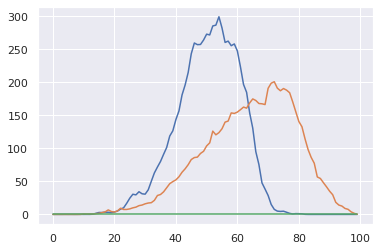

In [ ]:
#gráfico 12.
plt.plot(hiscg)
plt.plot(hisdm)
plt.plot(hiscg==hisdm)

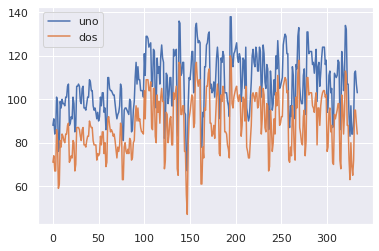

In [ ]:
#Gráfico 13. Posiciones de los vectores. Valores máximos de correlación entre histogra de los sujetos y las curvas promedios (gráfico 12)
plt.plot(np.argmax(correfCG, axis=1)) #Correlación todos los sujetos con curva promedio CG.
plt.plot(np.argmax(correfDM, axis=1)) #Correlación todos los sujetos con curva promedio DM.
plt.legend(['uno', 'dos'])

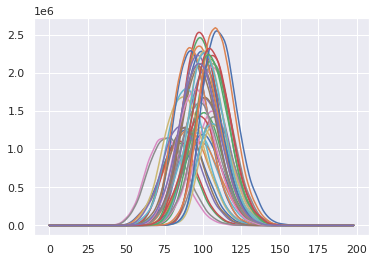

In [ ]:
#Gráfico 14. Grupo control con curva promedio de control
plt.plot(correfCG[:45].T)
print('')

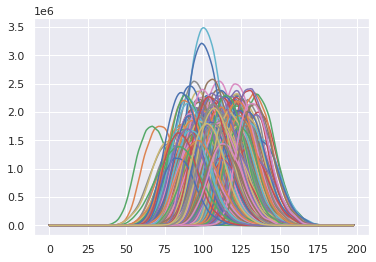

In [ ]:
#Gráfico 15. Grupo DM con curva promedio de control.
plt.plot(correfCG[45:].T)
print('')

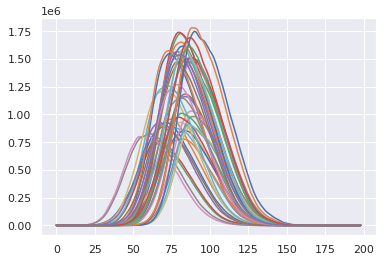

In [ ]:
#Gráfico 16. Grupo Control con curva promedio de DM.
plt.plot(correfDM[:45].T)
print('')

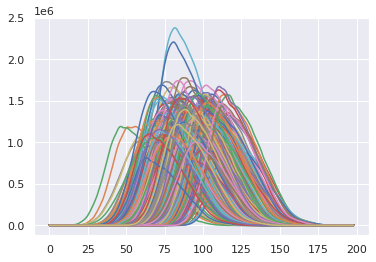

In [ ]:
#Gráfico 17. Grupo DM con curva promedio de DM.
plt.plot(correfDM[45:].T)
print('')

In [ ]:
corHis=np.zeros((int(np.shape(hisM0)[0]/2),int(2*np.shape(hisM0)[1]-1)))
for i in range(int(np.shape(hisM0)[0]/2)):
  corre=signal.correlate(hisM0[2*i],hisM0[2*i+1])
  corHis[i]=corre

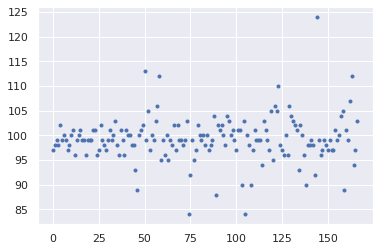

In [ ]:
#Gráfico 18. Correlación histograma entre ambos pies.
plt.plot(np.argmax(corHis, axis=1), '.')

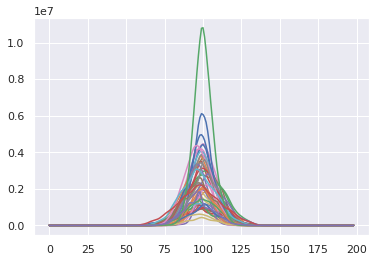

In [ ]:
#Gráfico 19. curvas de correlación CG del gráfico 18.
plt.plot(corHis[:45].T)
print('')

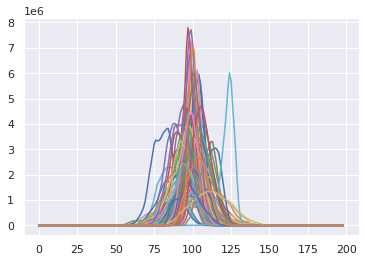

In [ ]:
#Gráfico 20. curvas de correlación DM del gráfico 18.
plt.plot(corHis[45:].T)
print('')

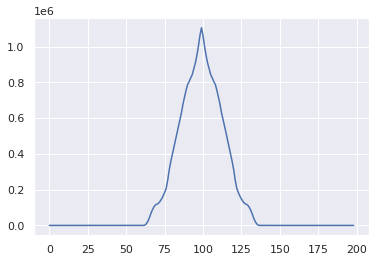

In [ ]:
#Gráfico 21. curvas de correlación del primer sujeto.
cor=signal.correlate(hisM0[0],hisM0[0])
plt.plot(cor)

In [ ]:
np.shape(cor)

(397, 175)

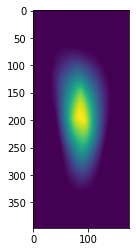

In [ ]:
#Gráfico 22. correlacion 2D. Se utilizó la imágenes originales.
plt.imshow(cor)

- correlación máxima
- difencial de temperaturas por angiosomas
- similaridad entre pies (todos los izquierdos y todos los derechos, sepatados CD, DM).
- fourier, replicar con PCA, isomap, cmds, lle, le, sne, tsne.
- Wavelet.

### Aumento de las imágenes

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def noise(x,y,per=0.1):
  per=1-per
  rand=np.random.rand(x,y)
  frac=(per)/(np.max(rand)-per)
  rand2=rand+frac
  rand2=rand2/np.max(rand2)
  return rand2

In [ ]:
def pca_images(data, percentage=0.1, ncomp=45):
  sz1=np.shape(data)
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])
  pca = PCA(n_components=ncomp)
  pca.fit(flat)
  space1=pca.transform(flat)
  x,y=np.shape(space1)
  new=np.zeros(sz1)
  rand=noise(x,y,percentage)
  ima=space1*rand
  ima=pca.inverse_transform(ima)
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  return ima

In [ ]:
def visualization_pca(data, name='none'):
  sz1=np.shape(data)
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])
  ncomp=np.min(np.shape(flat))
  pca = PCA(n_components=45)
  pca.fit(flat)

  comp1=pca.components_[0].reshape(*np.shape(data[0]))
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.title('First principal component')
  plt.imshow(comp1, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.plot(pca.explained_variance_ratio_)
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.title('Explained variance')
  plt.xlabel('Principal components')
  plt.ylabel('Varaince')
  plt.legend(['Explained variance', 'Cumulative explained variance'])
  plt.savefig(name+'.svg')
  print('Number of subjects :', ncomp)

Number of subjects : 45


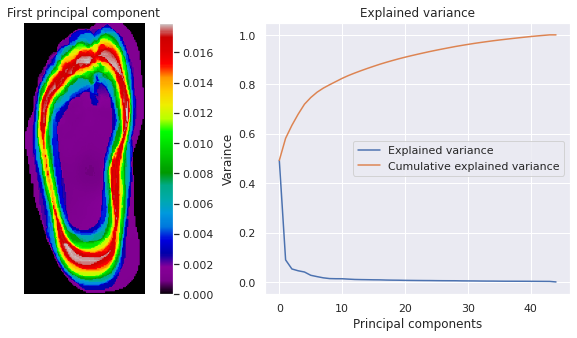

In [ ]:
#Gráfico 23. Sujetos sanos (Derecho)
visualization_pca(temp[Late=='R'][:45])

Number of subjects : 45


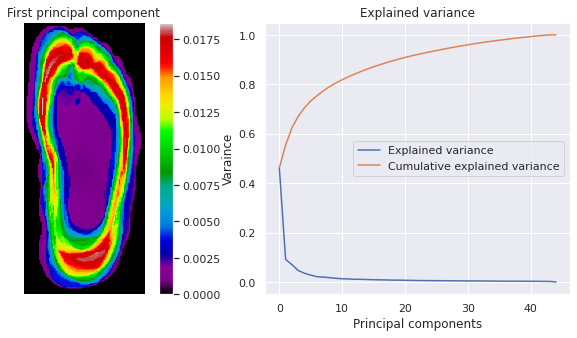

In [ ]:
#Gráfico 24. Sujetos sanos (Izquierdo)
visualization_pca(temp[Late=='L'][:45])

Number of subjects : 122


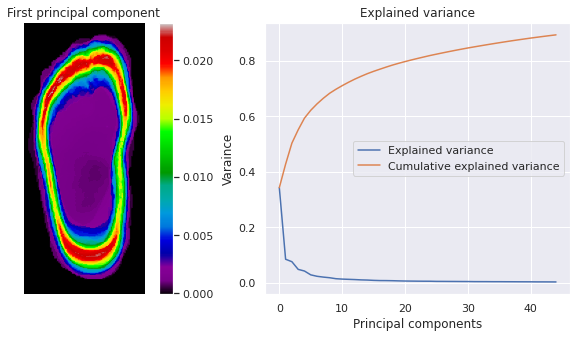

In [ ]:
#Gráfico 25. DM (Derecho)
visualization_pca(temp[Late=='R'][45:])

Number of subjects : 122


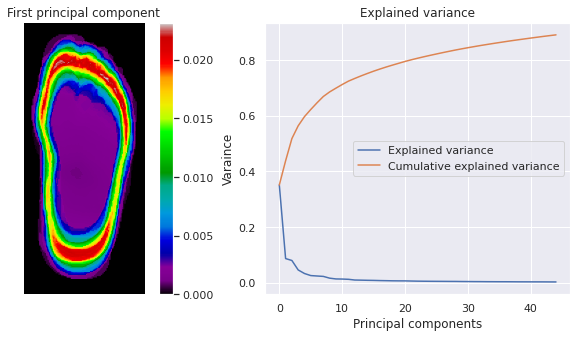

In [ ]:
#Gráfico 26. DM ((Izquierdo)
visualization_pca(temp[Late=='L'][45:])

### Generar nuevas imágenes con PCA

(-0.5, 87.5, 198.5, -0.5)

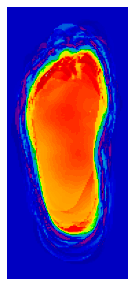

In [ ]:
plt.figure(figsize=(7,5))
plt.imshow(pca_images(temp[Late=='R'][45:])[np.random.choice(45)], cmap='nipy_spectral')
plt.axis('off')

### Isomap

- Método restringido a las matrices Semidefinidas positivas 
- La implentación no tiene inversa (Se puede calcular con PCA?)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE, SpectralEmbedding

In [ ]:
data=temp[Late=='R'][:45]
max0=500

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))[:,:max0]
embedding = Isomap(n_components=45)
X_transformed = embedding.fit_transform(flat)
X_transformed.shape

### manifold.MDS
classical multidimensional scaling
- Los métodos de embedding no tienen inversa

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
embedding = MDS(n_components=45)
X_transformed = embedding.fit_transform(flat)
X_transformed.shape

(45, 45)

### Locally Linear Embedding

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
embedding = LocallyLinearEmbedding(n_components=44)
X_transformed = embedding.fit_transform(flat)
X_transformed.shape

(45, 44)

### t-distributed stochastic neighbor embedding.
- El algoritmo **barnes hut** debe tener un número de componentes inferior a 4, ya que se basa en el árbol cuádruple o en el árbol de octuple.

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
embedding = TSNE(n_components=3,  learning_rate='auto', init='random')
X_transformed = embedding.fit_transform(flat)
X_transformed.shape

(45, 3)

### Spectral Embedding

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
embedding = SpectralEmbedding(n_components=43)
X_transformed = embedding.fit_transform(flat)
X_transformed.shape

(45, 43)

### Otros métodos de reducción de dimensiones

In [ ]:
from sklearn.decomposition import DictionaryLearning, FactorAnalysis, FastICA

### Dictionary Learning

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
dict_learner = DictionaryLearning(n_components=20, transform_algorithm='lasso_lars', random_state=42,)
X_transformed = dict_learner.fit_transform(flat)
X_transformed.shape

(45, 20)

(45, 20) (20, 17512)


(-0.5, 87.5, 198.5, -0.5)

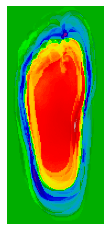

In [ ]:
print(np.shape(X_transformed), np.shape(dict_learner.components_))
x_hat=(X_transformed*np.random.rand(45,20))@dict_learner.components_
plt.imshow(x_hat[0].reshape(199,88), cmap='nipy_spectral')
plt.axis('off')

### Factor Analysis

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
FA = FactorAnalysis(n_components=45, random_state=0)
X_transformed = FA.fit_transform(flat)
X_transformed.shape

(45, 45)

(45, 45) (45, 17512)


(-0.5, 87.5, 198.5, -0.5)

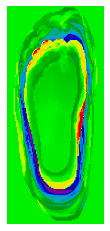

In [ ]:
print(np.shape(X_transformed), np.shape(FA.components_))
x_hat=(X_transformed*np.random.rand(45,45))@FA.components_
plt.imshow(x_hat[0].reshape(199,88), cmap='nipy_spectral')
plt.axis('off')

### ICA Independent Component Analysis

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
ICA = FastICA(n_components=40, random_state=0)
X_transformed = ICA.fit_transform(flat)
X_transformed.shape

(45, 40)

(45, 40) (40, 17512)


(-0.5, 87.5, 198.5, -0.5)

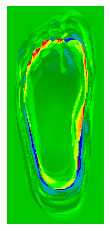

In [ ]:
print(np.shape(X_transformed), np.shape(ICA.components_))
x_hat=(X_transformed*np.random.rand(45,40))@ICA.components_
plt.imshow(x_hat[0].reshape(199,88), cmap='nipy_spectral')
plt.axis('off')

### Incremental PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA
from scipy import sparse

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
InPCA = IncrementalPCA(n_components=40, batch_size=200)

X_sparse = sparse.csr_matrix(flat)
X_transformed = InPCA.fit_transform(X_sparse)
X_transformed.shape

(45, 40)

(45, 40) (40, 17512)


(-0.5, 87.5, 198.5, -0.5)

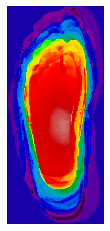

In [ ]:
print(np.shape(X_transformed), np.shape(InPCA.components_))
x_hat=InPCA.inverse_transform(X_transformed*np.random.rand(45,40))
plt.imshow(x_hat[0].reshape(199,88), cmap='nipy_spectral')
plt.axis('off')

### Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
kern = KernelPCA(n_components=40, kernel='linear', fit_inverse_transform=True)
X_transformed = kern.fit_transform(flat)
X_transformed.shape

(45, 40)

(-0.5, 87.5, 198.5, -0.5)

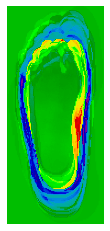

In [ ]:
x_hat=kern.inverse_transform(X_transformed*np.random.rand(45,40))
plt.imshow(x_hat[0].reshape(199,88), cmap='nipy_spectral')
plt.axis('off')

### Latent Dirichlet Allocation

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
lda = LatentDirichletAllocation(n_components=40, random_state=0)
X_transformed=lda.fit(flat)

new=X_transformed.transform(flat)

(45, 40) (40, 17512)


(-0.5, 87.5, 198.5, -0.5)

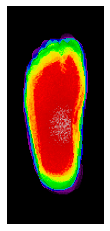

In [ ]:
print(np.shape(new), np.shape(X_transformed.components_))
x_hat=(new*np.random.rand(45,40))@X_transformed.components_
plt.imshow(x_hat[0].reshape(199,88), cmap='nipy_spectral')
plt.axis('off')

### Non-Negative Matrix Factorization

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
data=temp[Late=='R'][:45]

sz1=np.shape(data)
flat=data.reshape((sz1[0],sz1[1]*sz1[2]))
modelo=NMF(n_components=40, random_state=0)
X_transformed = modelo.fit_transform(flat)
X_transformed.shape

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


(45, 40)

(-0.5, 87.5, 198.5, -0.5)

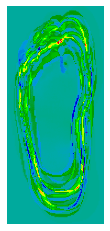

In [ ]:
x_hat=kern.inverse_transform(X_transformed*np.random.rand(45,40))
plt.imshow(x_hat[0].reshape(199,88), cmap='nipy_spectral')
plt.axis('off')

### Visualización de los todos los pies
9 columnas

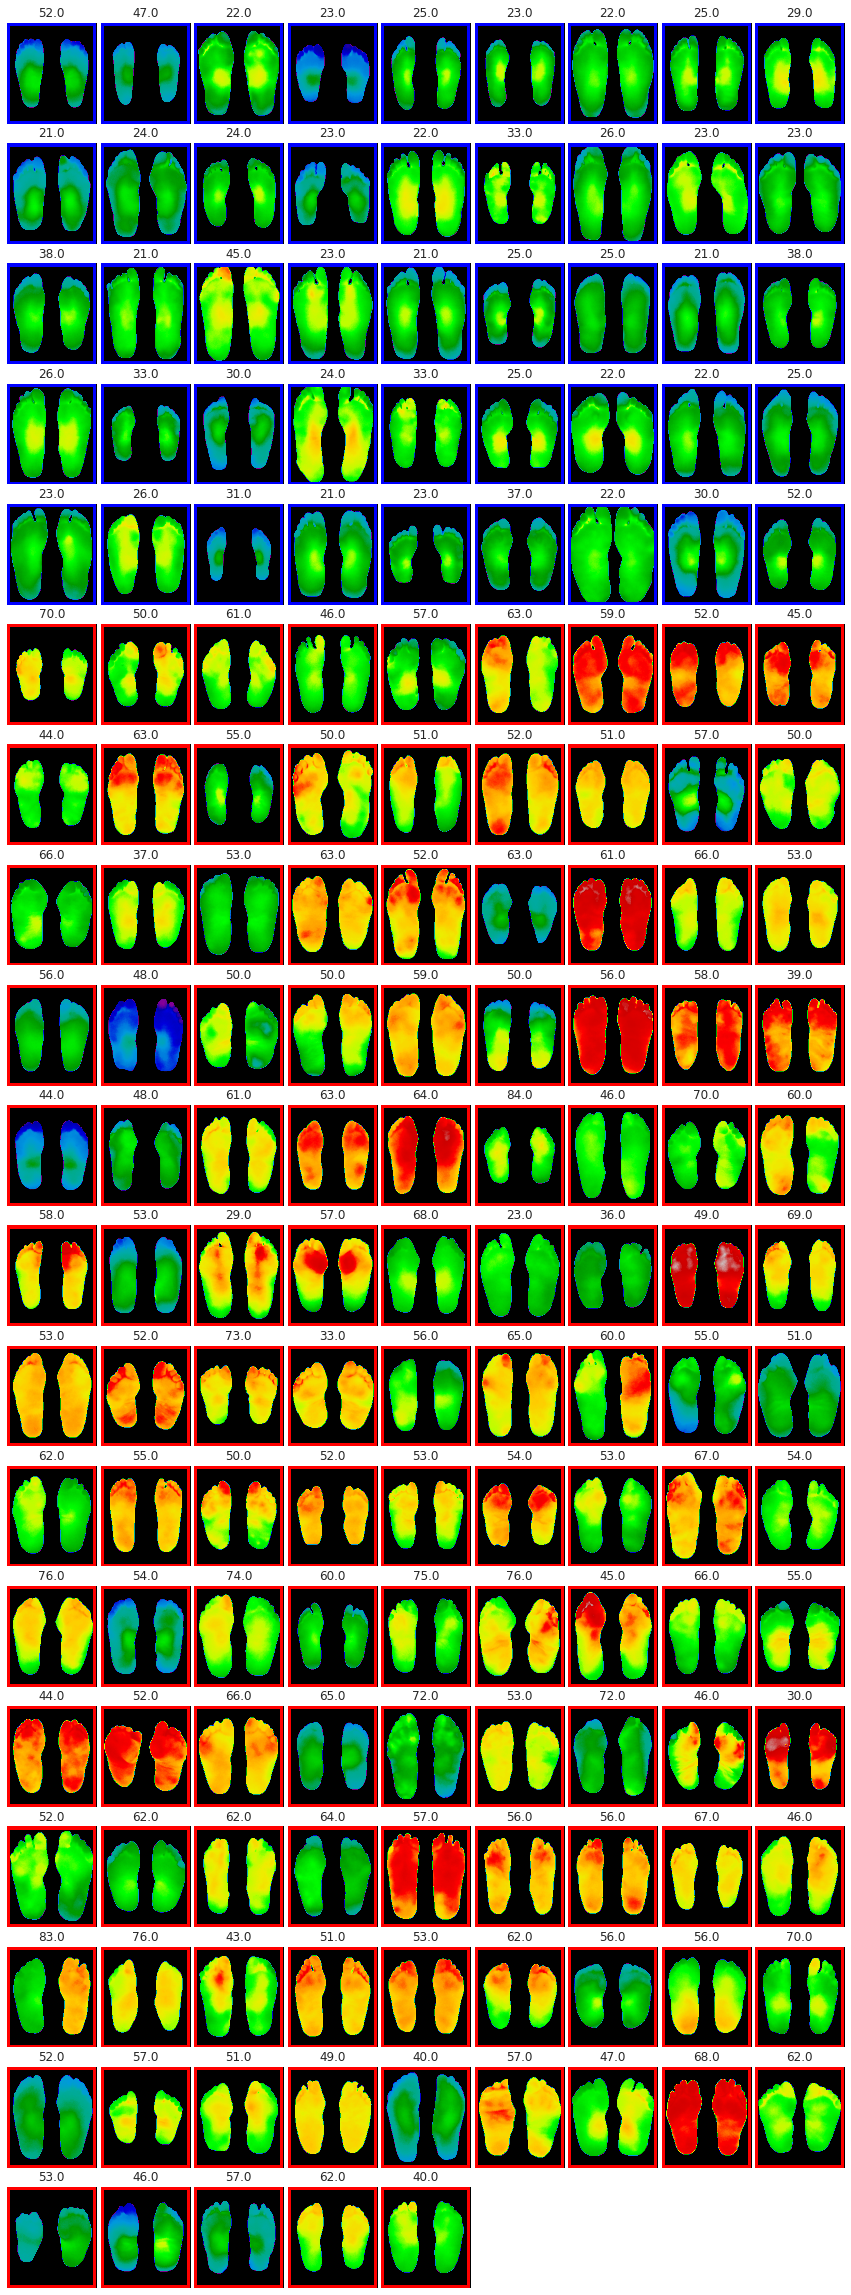

In [ ]:
plt.figure(figsize=(15,42))

for i in range(int(np.shape(temp)[0]/2)):
  uno=temp[2*i]
  dos=temp[2*i+1]
  if Late[2*i]=='R':
    sub=np.concatenate((uno, dos), axis=1)
  else:
    sub=np.concatenate((dos, uno), axis=1)
  plt.subplot(19,9,i+1)
  plt.imshow(sub, cmap='nipy_spectral', vmin=mini, vmax=maxi)
  plt.title(str(infA['Age'][0][2*i]))
  if labe[2*i]==0:
    plt.gca().add_patch(patches.Rectangle((0,0),176,199,  linewidth=6, edgecolor='blue', facecolor='none'))
  else:
    plt.gca().add_patch(patches.Rectangle((0,0),176,199,  linewidth=6, edgecolor='red', facecolor='none'))
  plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)

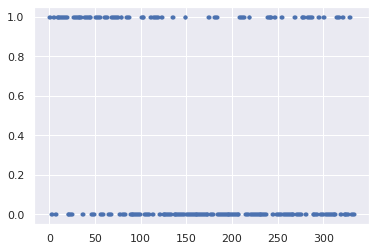

In [ ]:
plt.plot(Gend=='M', '.')

In [ ]:
stats.ttest_ind(coef[:45], coef[45:])

### 33
La base de datos tiene un sesgo por edades, los sujetos sanos tienen en promedio 27 años, mientras que los sujetos con DM tienen 56 años. Vale la pena aclarar, que la edad y el género son los únicos dataframe que están complentos.

In [ ]:
np.mean(infA['Age'][0][:90]), np.mean(infA['Age'][0][90:])

(27.755555555555556, 55.98360655737705)

In [ ]:
np.max(infA['Age'][0][:90]), np.min(infA['Age'][0][90:])

(52.0, 23.0)

### 34


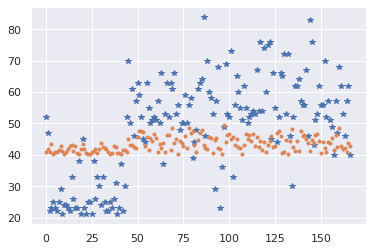

In [ ]:
plt.plot(infA['Age'][0][Late=='R'], '*')
plt.plot(40+infA['TCI'][0][Late=='R'], '.')

In [ ]:
def cls_SVM(cxx):
  y=np.concatenate((np.zeros(45), np.ones(122)))
  clf = svm.SVC(probability=True)
  clf.fit(cxx.reshape(-1, 1), y)
  res=clf.predict_proba(np.linspace(np.min(cxx), np.max(cxx), 1000).reshape(-1, 1))
  trh=np.linspace(np.min(cxx), np.max(cxx), 1000)[np.argmax((res[:,0]==res[:,1]).astype('int'))]
  return trh

$$Coef=T_{promedio Ambos Pies}+Edad^{2}+TCI_{izq}+TCI_{der}$$

In [ ]:
hv

1.0184984984984986

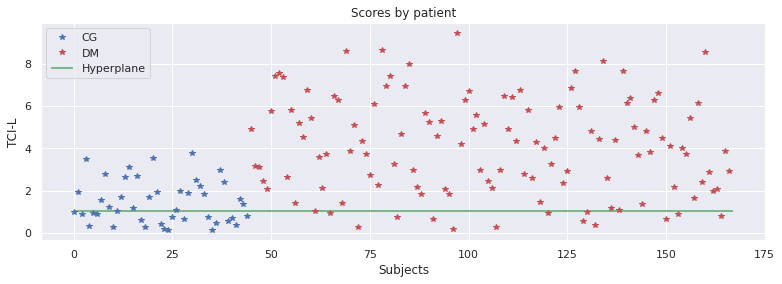

In [ ]:
edad=infA['Age'][0][Late=='R']
de=(np.sum(temp, axis=(1,2))/np.sum(temp!=0, axis=(1,2)))[Late=='R']
iz=(np.sum(temp, axis=(1,2))/np.sum(temp!=0, axis=(1,2)))[Late=='L']
dif=np.abs(de-iz)
me=(de+iz)/2 #Temperatura promedio de ambos pies.

coef=infA['TCI'][0][Late=='R']
hv=cls_SVM(coef)

plt.figure(figsize=(13,4))
plt.plot(coef[:45], '*b')
plt.plot(np.arange(122)+45, coef[45:], '*r')
plt.hlines(hv, 0, 167, 'g')
plt.legend(['CG', 'DM', 'Hyperplane'])
plt.title('Scores by patient')
plt.ylabel('TCI-L')
plt.xlabel('Subjects')
plt.savefig('/content/Figura_svm_coeficiente-Izquierdo.svg')

In [ ]:
unox=(labe[Late=='R']==1).astype('int')
dosx=(coef>hv).astype('int')

In [ ]:
np.mean(unox==dosx)

0.7544910179640718

In [ ]:
np.sum(coef[45:]>hv)

118

In [ ]:
TP=np.sum(coef[45:]>hv)
TN=np.sum(coef[:45]<hv)
FP=np.sum(coef[:45]>hv)
FN=np.sum(coef[45:]<hv)

print( 'Accuracy', (TP+TN)*100/(TP+TN+FP+FN))
print('F1_score', (2*TP)*100/(2*TP+FP+FN))
print('Sensitivity', TP*100/(TP+FN))
print('Specificity', TN*100/(TN+FP))
print('Precision', TP*100/(TP+FP))

Accuracy 75.44910179640719
F1_score 85.1985559566787
Sensitivity 96.72131147540983
Specificity 17.77777777777778
Precision 76.12903225806451


In [ ]:
from scipy import stats

In [ ]:
stats.ttest_ind(coef[:45], coef[45:])

Ttest_indResult(statistic=-17.65487677563, pvalue=7.430707308289061e-40)

### (valor p = 0) <0.05
Hipotesis nula falsa. Ergo el coeficiente indica que las dos poblaciones provienen de diferentes distribuciones.

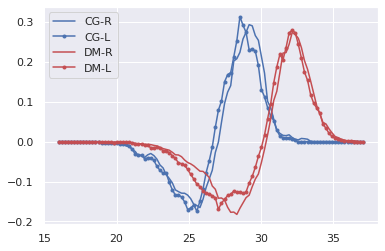

In [ ]:
nco=0
plt.plot(x[:-1], pca_h0.components_[nco], 'b')
plt.plot(x[:-1], pca_h1.components_[nco], '.-b')
plt.plot(x[:-1], pca_h2.components_[nco], 'r')
plt.plot(x[:-1], pca_h3.components_[nco], '.-r')
plt.legend(['CG-R', 'CG-L', 'DM-R', 'DM-L'])

In [ ]:
from scipy import signal

Pendiente máxima : 30.462360000000004


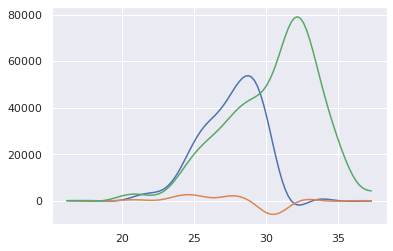

In [ ]:
b, a = signal.butter(4, 0.125)
ycg = signal.filtfilt(b, a, np.var(hisM0[:90], axis=0), padlen=3)
ydm = signal.filtfilt(b, a, np.var(hisM0[90:], axis=0), padlen=3)

gf=1
der=np.diff(ycg, gf)
print('Pendiente máxima :', x[1+gf:][np.argmin(der)])
plt.plot(x[1:], ycg)
plt.plot(x[1+gf:], der)
plt.plot(x[1:], ydm)

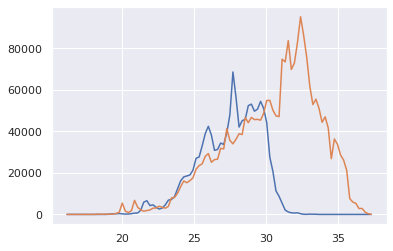

In [ ]:
plt.plot(x[1:],np.var(hisM0[:90], axis=0))
plt.plot(x[1:],np.var(hisM0[90:], axis=0))

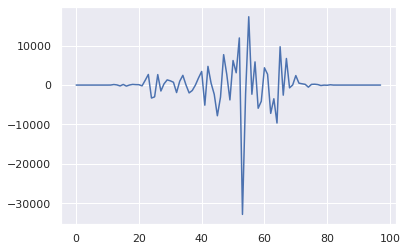

In [ ]:
plt.plot(np.diff(np.var(hisM0[:90], axis=0), 2))

In [ ]:
x[np.argmin(np.diff(np.var(hisM0[:90], axis=0)))]

29.823300000000003

In [ ]:
first=np.concatenate((pca_h0.components_[0],pca_h1.components_[0],pca_h2.components_[0],pca_h3.components_[0]), axis=0).reshape(4,100)

x[:-1][np.argmin(first, axis=1)]
x[1:][np.argmin(first, axis=1)]

x[:-1][np.argmax(first, axis=1)]
x[1:][np.argmax(first, axis=1)]

array([29.39726, 28.7582 , 32.37954, 32.37954])

In [ ]:
LCA=infA['LCA'][0]
LPA=infA['LPA'][0]
MCA=infA['MCA'][0]
MPA=infA['MPA'][0]
TCI=infA['TCI'][0]

### 37
Los puntajes generados por los angiosomas son estadísticamente diferentes entre sujetos CG y DM. Con valores p inferiores al 0.05. 

In [ ]:
print(stats.ttest_ind(infA['General'][0][:90],infA['General'][0][90:]))
print(stats.ttest_ind(LCA[:90], LCA[90:]))
print(stats.ttest_ind(LPA[:90], LPA[90:]))
print(stats.ttest_ind(MCA[:90], MCA[90:]))
print(stats.ttest_ind(MPA[:90], MPA[90:]))
print(stats.ttest_ind(TCI[:90], TCI[90:]))

Ttest_indResult(statistic=-9.351176173206483, pvalue=1.3233213193397135e-18)
Ttest_indResult(statistic=-8.760911808795317, pvalue=1.0117506968644061e-16)
Ttest_indResult(statistic=-9.671772321785113, pvalue=1.1743275526789277e-19)
Ttest_indResult(statistic=-8.400987323424177, pvalue=1.3100568868069879e-15)
Ttest_indResult(statistic=-9.648241999673553, pvalue=1.4049190999687492e-19)
Ttest_indResult(statistic=-10.410657128635016, pvalue=3.7569466979495468e-22)


In [ ]:
print(stats.ttest_ind(infA['Age'][0][:90], infA['Age'][0][90:]))

Ttest_indResult(statistic=-22.903832486113394, pvalue=2.6042408801198102e-70)


In [ ]:
print(stats.ttest_ind((info['Gender'][:122]=='M').astype('int'), (info['Gender'][122:]=='M').astype('int')))

Ttest_indResult(statistic=-4.696807350483052, pvalue=5.534318866959016e-06)


In [ ]:
np.sum(info['Gender'][:122]=='M')*100/122, np.sum(info['Gender'][122:]=='M')*100/45

(27.049180327868854, 64.44444444444444)

In [ ]:
np.sum(info['Gender'][:122]=='F')*100/122, np.sum(info['Gender'][122:]=='F')*100/45

(72.95081967213115, 35.55555555555556)

### Diferencias estadísticas entre pies

In [ ]:
print(stats.ttest_ind(infA['General'][0][Late=='R'][:45], infA['General'][0][Late=='L'][:45]))
print(stats.ttest_ind(infA['General'][0][Late=='R'][45:], infA['General'][0][Late=='L'][45:]))

print(stats.ttest_ind(infA['LCA'][0][Late=='R'][:45], infA['LCA'][0][Late=='L'][:45]))
print(stats.ttest_ind(infA['LCA'][0][Late=='R'][45:], infA['LCA'][0][Late=='L'][45:]))

print(stats.ttest_ind(infA['LPA'][0][Late=='R'][:45], infA['LPA'][0][Late=='L'][:45]))
print(stats.ttest_ind(infA['LPA'][0][Late=='R'][45:], infA['LPA'][0][Late=='L'][45:]))

print(stats.ttest_ind(infA['MCA'][0][Late=='R'][:45], infA['MCA'][0][Late=='L'][:45]))
print(stats.ttest_ind(infA['MCA'][0][Late=='R'][45:], infA['MCA'][0][Late=='L'][45:]))

print(stats.ttest_ind(infA['MPA'][0][Late=='R'][:45], infA['MPA'][0][Late=='L'][:45]))
print(stats.ttest_ind(infA['MPA'][0][Late=='R'][45:], infA['MPA'][0][Late=='L'][45:]))

print(stats.ttest_ind(infA['TCI'][0][Late=='R'][:45], infA['TCI'][0][Late=='L'][:45]))
print(stats.ttest_ind(infA['TCI'][0][Late=='R'][45:], infA['TCI'][0][Late=='L'][45:]))

Ttest_indResult(statistic=0.0812778910683018, pvalue=0.9354055282932838)
Ttest_indResult(statistic=0.32341458002820833, pvalue=0.7466605889021083)
Ttest_indResult(statistic=0.17754804735786003, pvalue=0.8594859726411043)
Ttest_indResult(statistic=0.33751229320465104, pvalue=0.73602331231666)
Ttest_indResult(statistic=0.06613420143842545, pvalue=0.9474209988988216)
Ttest_indResult(statistic=0.35511620678050554, pvalue=0.7228118371196729)
Ttest_indResult(statistic=0.21901606542335464, pvalue=0.8271447078641472)
Ttest_indResult(statistic=0.25515049195467443, pvalue=0.7988235773912091)
Ttest_indResult(statistic=0.113129471431296, pvalue=0.9101855930310279)
Ttest_indResult(statistic=0.1756876826143624, pvalue=0.8606862307450707)
Ttest_indResult(statistic=0.07356989380926257, pvalue=0.9415195973643999)
Ttest_indResult(statistic=0.35470221328650403, pvalue=0.7231215983496276)


### Siguientes.
Descripción de histogramas.
-Nuevo coeficientes (Hallazgo de los datos).
-Aumento de datos PCA. Todas las transformaciones que tienen inversa. Transformer, flip, cambio de espacio de color, Noise.
-Indice de Corvo.